In [12]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.io as pio
pio.renderers.default = 'notebook'

# Loading Data

In [90]:
pool_urls = {}

pool_urls["USDC"] = """
# token defined above

https://defillama.com/yields/pool/aa70268e-4b52-42bf-a116-608b370f9501

https://defillama.com/yields/pool/d9fa8e14-0447-4207-9ae8-7810199dfa1f

https://defillama.com/yields/pool/7e0661bf-8cf3-45e6-9424-31916d4c7b84

https://defillama.com/yields/pool/a349fea4-d780-4e16-973e-70ca9b606db2

https://defillama.com/yields/pool/37b04faa-95bb-4ccb-9c4e-c70fa167342b

https://defillama.com/yields/pool/1b8b4cdb-0728-42a8-bf13-2c8fea7427ee

https://defillama.com/yields/pool/0758c3b8-4ffb-4176-b0a9-f446e367db46

#https://defillama.com/yields/pool/745b5b20-c9dc-4d3e-8c74-9fa3d3d81830

https://defillama.com/yields/pool/7aab7b0f-01c1-4467-bc0d-77826d870f19

https://defillama.com/yields/pool/15cf7c05-b5f0-4bde-8745-a791528c4381

https://defillama.com/yields/pool/766ccc08-ba7c-4f94-b2fd-336ccc53c53b

https://defillama.com/yields/pool/5e498f38-9d6f-49b7-a197-9068103f9866

"""


def url_raw_to_pool_id(url_raw):
  return [url.split("/")[-1] for url in  url_raw.split("\n")[1:-1] if "#" not in url]

pool_ids = {t:url_raw_to_pool_id(pool_ids) for t, pool_ids in pool_urls.items()}

In [91]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [92]:
data, borrow_lend_data = maestro.load_defilama_with_token_pool_id(pool_ids)

USDC
Ethereum:aave-v3:USDC aa70268e-4b52-42bf-a116-608b370f9501 519 519
Arbitrum:aave-v3:USDC d9fa8e14-0447-4207-9ae8-7810199dfa1f 492 492
Ethereum:aave-v2:USDC a349fea4-d780-4e16-973e-70ca9b606db2 517 517
Base:aave-v3:USDC 7e0661bf-8cf3-45e6-9424-31916d4c7b84 236 236
Polygon:aave-v3:USDC 37b04faa-95bb-4ccb-9c4e-c70fa167342b 514 514
Polygon:aave-v3:USDC 1b8b4cdb-0728-42a8-bf13-2c8fea7427ee 316 316
Optimism:aave-v3:USDC 0758c3b8-4ffb-4176-b0a9-f446e367db46 339 339
Arbitrum:aave-v3:USDC 7aab7b0f-01c1-4467-bc0d-77826d870f19 514 514
Gnosis:aave-v3:USDC 766ccc08-ba7c-4f94-b2fd-336ccc53c53b 281 281
BSC:aave-v3:USDC 15cf7c05-b5f0-4bde-8745-a791528c4381 144 144
zkSync Era:aave-v3:USDC 5e498f38-9d6f-49b7-a197-9068103f9866 23 23


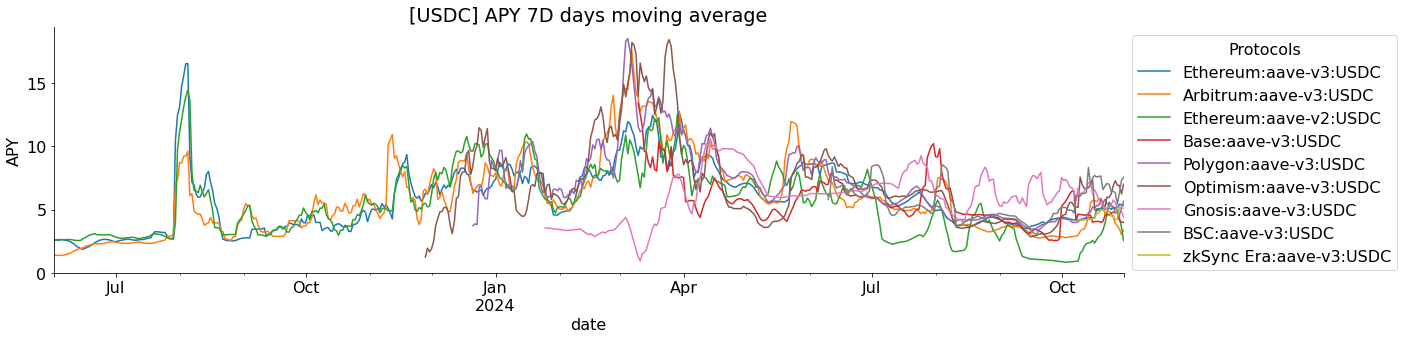

In [93]:
maestro.set_data(borrow_lend_data)
maestro.plot_rates_ts(agg_str="7D")

In [8]:
token = "USDC"

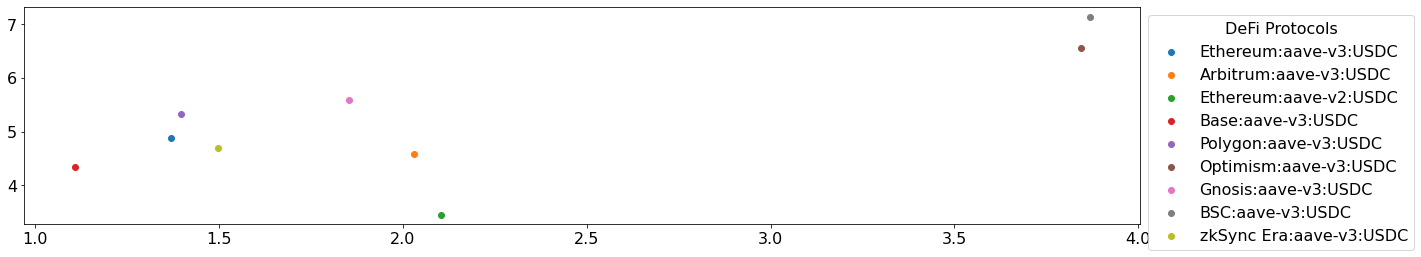

In [94]:
df = borrow_lend_data.as_block(token)
mus = df.apyBase.dropna().mean()
sigma = df.apyBase.dropna().std()
for c in df.apyBase.columns:
  plt.scatter(sigma[c], mus[c], label=c)
_ = plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="DeFi Protocols")

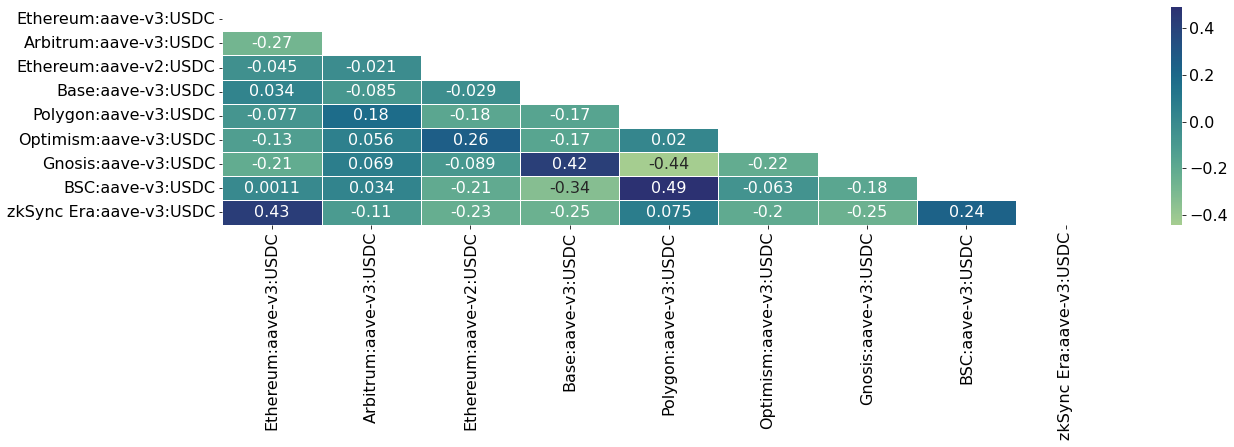

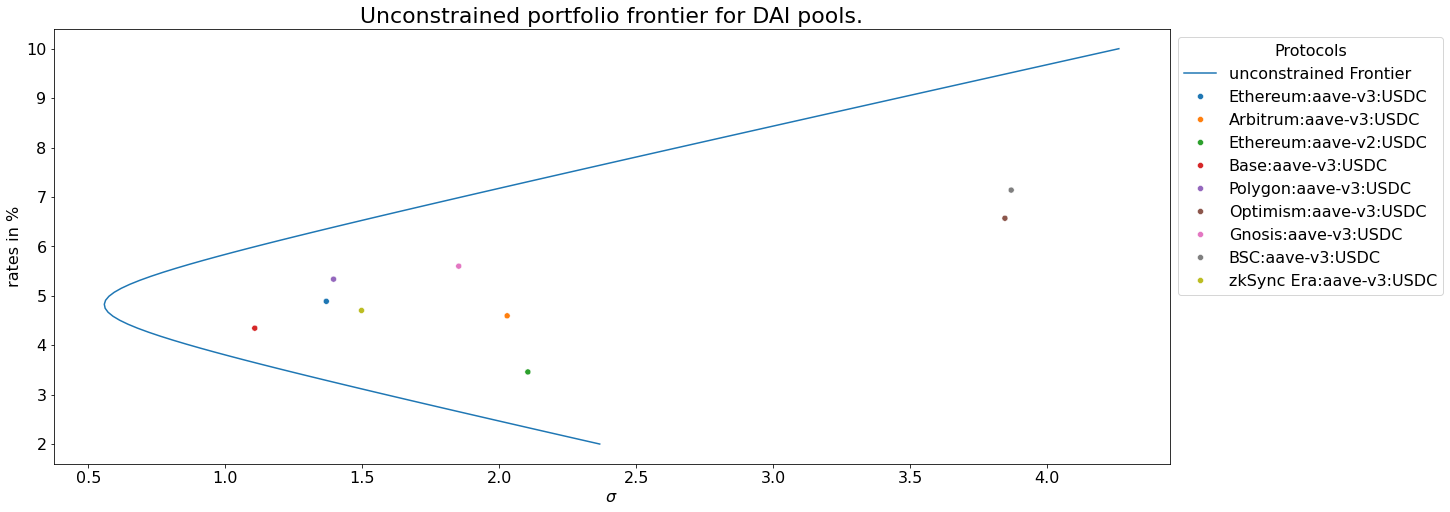

In [95]:
tmp = df.apyBase.dropna()
mus = tmp.mean()
sigmas = tmp.std()
corr_matrix = tmp.corr().values

cov = np.diag(sigmas) * corr_matrix * np.diag(sigmas)
inv_cov = np.linalg.inv(cov)

iota = np.ones((len(cov),1))

matrix = np.triu(corr_matrix)
_ = sns.heatmap(
  corr_matrix,
  annot=True,
  linewidth=.5,
  cmap="crest",
  yticklabels=list(tmp.keys()),
  xticklabels=list(tmp.keys()),
  mask=matrix
)
summary = pd.DataFrame()
summary["mu"] = mus
summary["sigma"] = sigmas
summary["pool"] = [k for k in list(tmp.keys())]

a = ((iota.T @ inv_cov @ iota))[0][0]
b = float((iota.T @ inv_cov @ mus)[0])
c = float((mus.T @ inv_cov @ mus))

# Use analytical results to get explicit closed-form hyperbola envelope function
y = np.linspace(0.02*100, 0.1*100, 100)
x = np.sqrt((a*y**2 - 2*b*y + c)/(a*c-b**2))
plt.figure(figsize=(20,8))
plt.plot(x,y, color="tab:blue", label="unconstrained Frontier")
sns.scatterplot(x="sigma", y="mu", data=summary, hue="pool", ax=plt.gca())
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Protocols")
plt.title("Unconstrained portfolio frontier for DAI pools.", fontsize=22)
plt.ylabel("rates in %", fontsize=16)
_ = plt.xlabel("$\\sigma$", fontsize=16)
#_ = plt.title("Efficient Frontier")

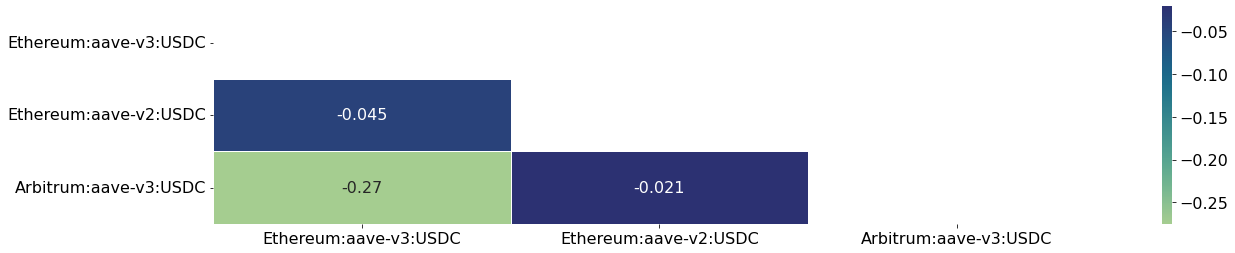

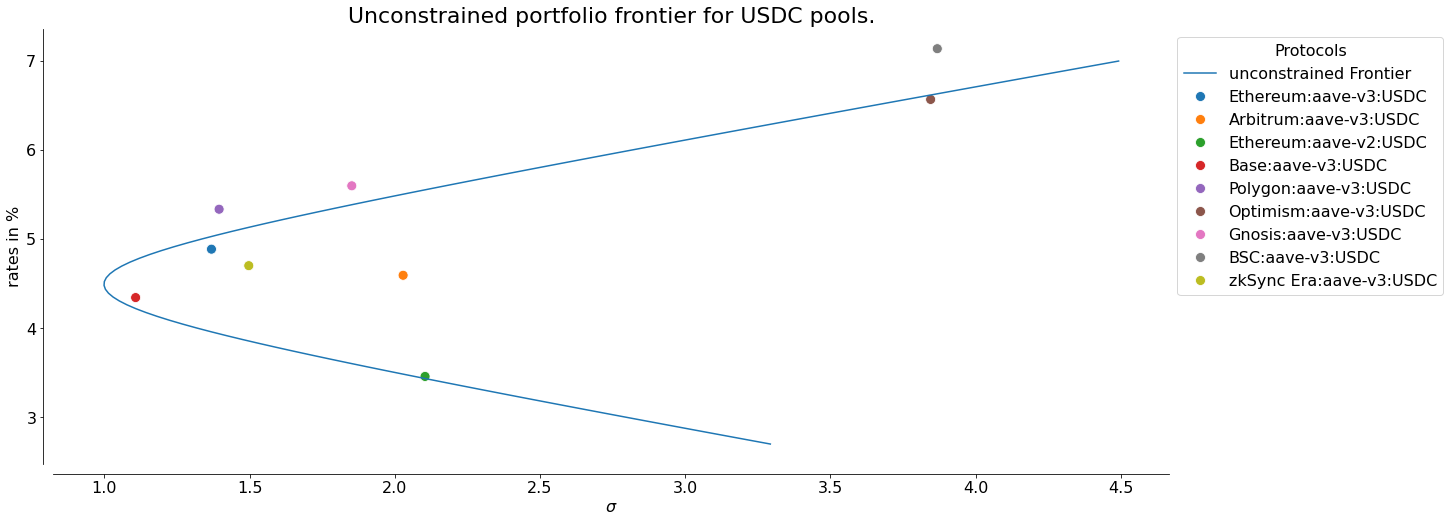

In [96]:
cols = ["Ethereum:aave-v3:USDC", "Ethereum:aave-v2:USDC", "Arbitrum:aave-v3:USDC"]
tmp = df.apyBase.dropna()[cols]
mus = tmp.mean()
sigmas = tmp.std()
corr_matrix = tmp.corr().values

cov = np.diag(sigmas) * corr_matrix * np.diag(sigmas)
inv_cov = np.linalg.inv(cov)

iota = np.ones((len(cov),1))

matrix = np.triu(corr_matrix)
_ = sns.heatmap(
  corr_matrix,
  annot=True,
  linewidth=.5,
  cmap="crest",
  yticklabels=list(tmp.keys()),
  xticklabels=list(tmp.keys()),
  mask=matrix
)



a = ((iota.T @ inv_cov @ iota))[0][0]
b = float((iota.T @ inv_cov @ mus)[0])
c = float((mus.T @ inv_cov @ mus))

# Use analytical results to get explicit closed-form hyperbola envelope function

tmp = df.apyBase.dropna()
mus = tmp.mean()
sigmas = tmp.std()

summary = pd.DataFrame()
summary["mu"] = mus
summary["sigma"] = sigmas
summary["pool"] = [k for k in list(tmp.keys())]

y = np.linspace(0.027*100, 0.07*100, 100)
x = np.sqrt((a*y**2 - 2*b*y + c)/(a*c-b**2))
plt.figure(figsize=(20,8))
plt.plot(x,y, color="tab:blue", label="unconstrained Frontier")
sns.scatterplot(x="sigma", y="mu", data=summary, hue="pool", ax=plt.gca(), s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Protocols")
plt.title("Unconstrained portfolio frontier for USDC pools.", fontsize=22)
plt.ylabel("rates in %", fontsize=16)
_ = plt.xlabel("$\\sigma$", fontsize=16)
#_ = plt.title("Efficient Frontier")
ax = plt.gca()
# Remove the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optionally, you can also move the left and bottom spines
ax.spines["left"].set_position(("outward", 10))
ax.spines["bottom"].set_position(("outward", 10))

# Slippage Models

In [97]:
from dope.market_impact.neighborhood import NeighborhoodMktImpactModel

In [98]:
mkt_model = NeighborhoodMktImpactModel()

2023-09-09 00:00:00


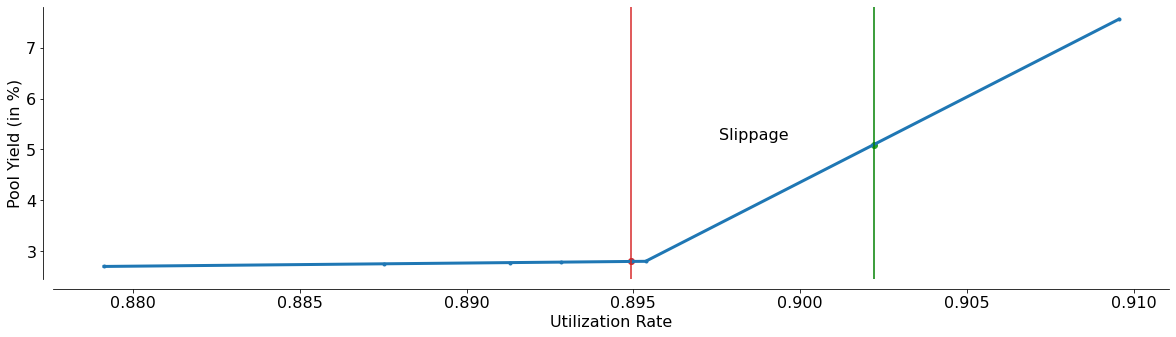

In [141]:
mkt = "Ethereum:aave-v3:USDC"
mkt_model.set_data_ref(borrow_lend_data[token][mkt])
date_now = borrow_lend_data[token][mkt].index[100]
print(date_now)
_ = mkt_model.impact(date_now,  2_000_000, is_borrow=True, should_plot=True)

# Backtest

In [114]:
# import agents
from dope.backengine.agents.jackreaper import LenderJackReaper
from dope.backengine.agents.quadratic import LenderQuadratic

from dope.backengine.agents.txcosts import LenderMIQP

In [102]:
from dope.backengine.arbengine import ArbBacktester
from dope.backengine.runsummary import BacktestSummary

In [125]:
summaries = {}
CAPITAL = 1_000_000

# Setup data
run_data = borrow_lend_data

# Daily triggers for benchmark
triggers = run_data.to_block(token).utilizationRate.resample("7D").last().index[1:]
# Setup strategy

for λ in [0, 0.5, 1, 2]:

  strategy = LenderQuadratic(
    token=token,
    capital=CAPITAL,
    risk_aversion=λ,
    mean_window=7,
    cov_window=7,
    #triggers=triggers
  )
  strategy.verbose = False

  # setup backtest
  arbt = ArbBacktester(
    strategy=strategy,
    borrow_lend_data=run_data,
    data=run_data,
  )

  # Run Backtest
  summaries[f"QP:λ={λ}"], _ = arbt(start_timestamp="2024-08-01")

Running Backtest for 519 | token:USDC
Running Backtest for 519 | token:USDC
Running Backtest for 519 | token:USDC
Running Backtest for 519 | token:USDC


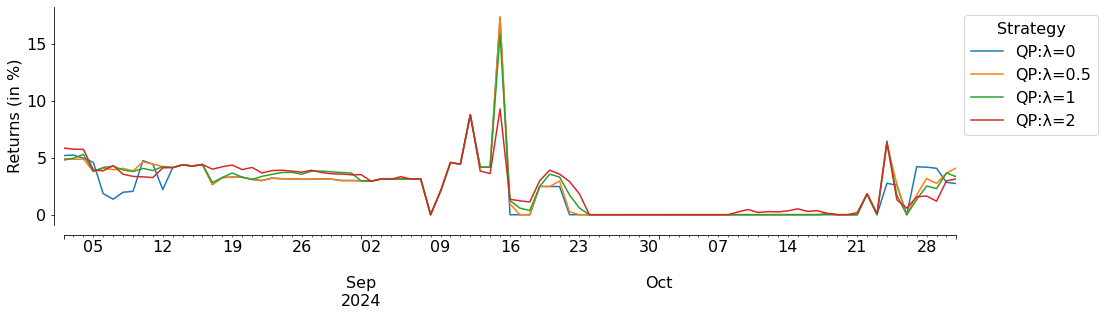

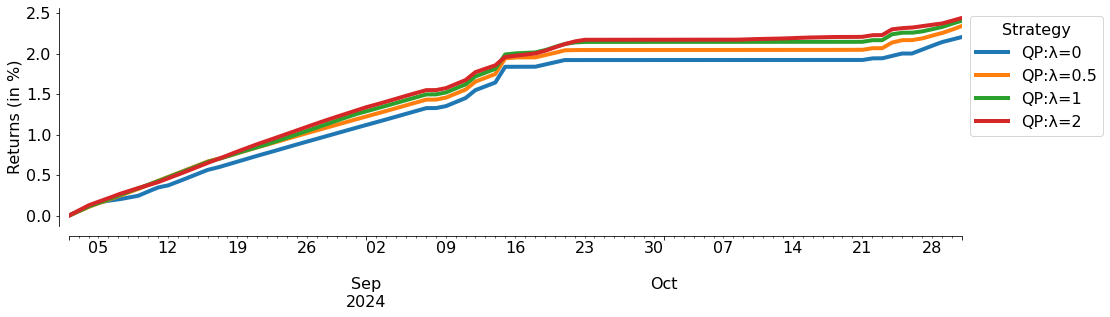

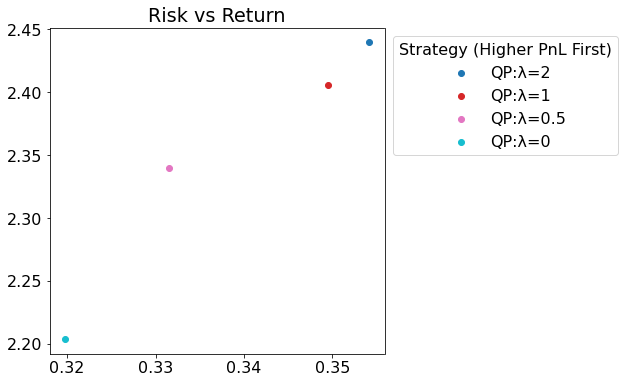

QP:λ=2      2.439384
QP:λ=1      2.405530
QP:λ=0.5    2.339690
QP:λ=0      2.203863
dtype: float64


In [126]:
from dope.backengine.plotting.simple import Plotter
plot = Plotter(summaries)
plot.summary_view()

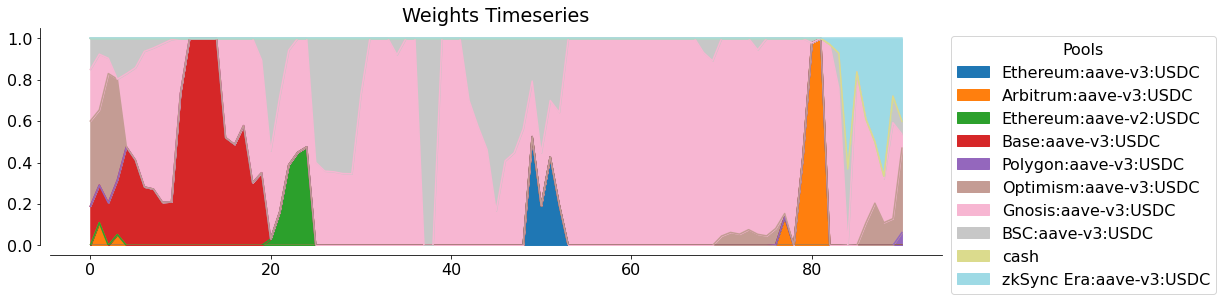

In [127]:
plot.weights_timeseries("QP:λ=2")